<a href="https://colab.research.google.com/github/afrahhassan/afrahhassan/blob/main/assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
## Task
This report will analyse the methodology used to complete assignment 2 of the course Machine Learning (COSC2673/2793). The objective of the assignment is to develop a machine-learning system that can classify traffic sign images.

The project is divided into two tasks:


*   Classify images according to the shape of the given image.
*    Classify images according to type.



## Approach
Our goal is to be able to identify the best possible machine-learning algorithm to generate a model that can reliably and consistently predict whether the type of traffic sign is based on image recognition.

# Reading Data

In [ ]:
from google.colab import drive
import os
import csv
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
!cp -r "/content/drive/MyDrive/Assignment2" .

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Assignment2/trafficsigns_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

create a type csv

In [ ]:
root_dir = '/content/trafficsigns_dataset'
output_csv = '/content/drive/My Drive/Assignment2/type.csv'
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_path', 'class'])

    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                full_path = os.path.join(root, file)
                class_name = os.path.basename(root)
                writer.writerow([full_path, class_name])
print("CSV file has been created successfully.")

CSV file has been created successfully.


Train type dataset

In [ ]:
dataType= pd.read_csv('/content/drive/My Drive/Assignment2/type.csv')

train_data, test_data = train_test_split(dataType, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 2219, Val Data: 740, Test Data: 740


In [ ]:
dataType.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3699 entries, 0 to 3698
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3699 non-null   object
 1   class       3699 non-null   object
dtypes: object(2)
memory usage: 57.9+ KB


create a type csv and encoding classes

In [ ]:
import cv2
output_csv = '/content/drive/My Drive/Assignment2/shape.csv'

class_mapping = {}

with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_path', 'class', 'encoded_class'])

    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                full_path = os.path.join(root, file)
                class_name = os.path.basename(os.path.dirname(root))

                if class_name not in class_mapping:
                    class_mapping[class_name] = len(class_mapping)

                # Read and resize the image to (28, 28)
                image = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
                resized_image = cv2.resize(image, (28, 28))

                # Expand the dimensions to add the channel dimension
                resized_image = np.expand_dims(resized_image, axis=-1)

                writer.writerow([full_path, class_name, class_mapping[class_name]])

print("CSV file has been created successfully.")


CSV file has been created successfully.


Train shape dataset

In [ ]:
dataShape= pd.read_csv('/content/drive/My Drive/Assignment2/shape.csv')

train_data, test_data = train_test_split(dataShape, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 2219, Val Data: 740, Test Data: 740


# EDA

# Model development

## Base Model

In [ ]:
INPUT_DIM = (28, 28, 1)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 5

In [ ]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.15.0'

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               200960    
                                                                 
 dense_3 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 202245 (790.02 KB)
Trainable params: 202245 (790.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


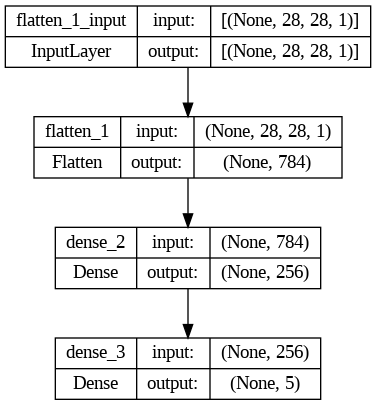

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)


In [ ]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [ ]:
train_data['class'] = train_data['class'].astype('str')
val_data['class'] = val_data['class'].astype('str')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 20

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./dataShape/train',
        x_col="image_path",
        y_col="class",
        target_size=(28, 28),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./dataShape/validation',
        x_col="image_path",
        y_col="class",
        target_size=(28, 28),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical')

Found 2219 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.


In [ ]:
print("Shape of training data generated by train_generator:", train_generator.image_shape)
print("Shape of validation data generated by validation_generator:", validation_generator.image_shape)


Shape of training data generated by train_generator: (28, 28, 1)
Shape of validation data generated by validation_generator: (28, 28, 1)


In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=50, verbose=0)


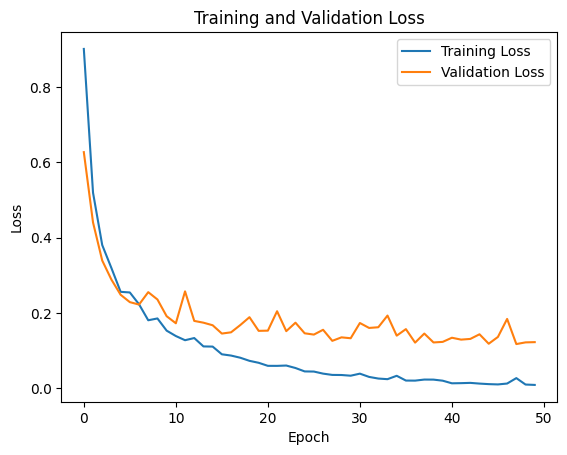

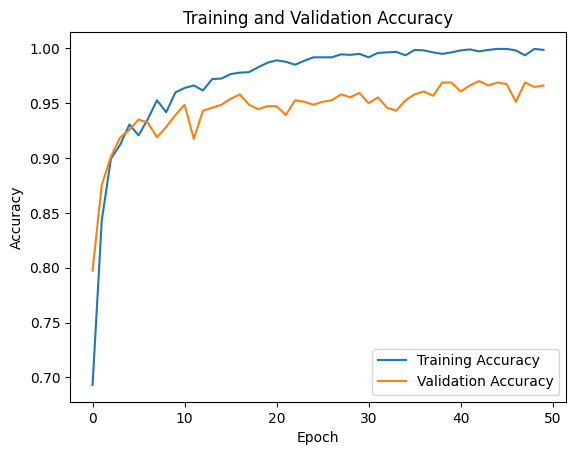

In [ ]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [ ]:
plot_learning_curve(history.history['loss'], history.history['val_loss'],
                    history.history['accuracy'], history.history['val_accuracy'],
                    metric_name='Accuracy')


NameError: name 'plot_learning_curve' is not defined

In [ ]:
test_data['class'] = test_data['class'].astype('str')


test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="image_path",
        y_col="class",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')


Found 740 validated image filenames belonging to 5 classes.


In [ ]:
import numpy as np
import cv2

# Initialize an empty list to store the processed images
processed_images = []

# Iterate through each test image
for i in range(len(test_generator)):
    # Get the image
    image = test_generator[i][0]

    # Check if the image is already grayscale
    if image.shape[-1] != 1:
        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray_image = image.squeeze()  # Remove the color channel if it's already a single channel image

    # Ensure the shape is (28, 28)
    resized_image = cv2.resize(gray_image, (28, 28))

    # Expand the dimensions to make it (28, 28, 1)
    expanded_image = np.expand_dims(resized_image, axis=-1)

    # Append the processed image to the list
    processed_images.append(expanded_image)

# Convert the list of processed images to a numpy array
processed_images_array = np.array(processed_images)

# Print the shape of the processed images array
print("Shape of processed images:", processed_images_array.shape)



error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [ ]:
print("Shape of training data:", train_generator.image_shape)
print("Shape of validation data:", validation_generator.image_shape)
print("Shape of test images:", test_generator.image_shape)
print("Shape of test labels:", test_generator.labels.shape)


Shape of training data: (28, 28, 1)
Shape of validation data: (28, 28, 1)
Shape of test images: (28, 28, 3)


AttributeError: 'list' object has no attribute 'shape'

In [ ]:
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Dense):
        print("Weights shape in layer:", layer.name, ":", layer.weights[0].shape)


Weights shape in layer: dense_2 : (784, 256)
Weights shape in layer: dense_3 : (256, 5)


In [ ]:
evaluation = model.evaluate(test_generator)

InvalidArgumentError: Graph execution error:

Detected at node sequential_1/dense_2/BiasAdd defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-60-e529ab2e5327>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1856, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2296, in evaluate

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 4108, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2066, in test_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2049, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2037, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1917, in test_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/sequential.py", line 398, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py", line 252, in call

Matrix size-incompatible: In[0]: [1,2352], In[1]: [784,256]
	 [[{{node sequential_1/dense_2/BiasAdd}}]] [Op:__inference_test_function_33629]

In [ ]:
print("Number of batches in the test generator:", len(test_generator))


Number of batches in the test generator: 740


In [ ]:
label_names = {'diamond' : 0, 'hex' : 1, 'triangle' : 2, 'square' : 3, 'round' : 4}


In [ ]:
label_names

{'diamond': 0, 'hex': 1, 'triangle': 2, 'square': 3, 'round': 4}

### Compile the model


### Set up the layers

### Train the model

In [ ]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

### Incremental changes

# Testing the final model